In [227]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import pandas as pd
from time import time

# 1. Load and prepare MNIST data

In [228]:
transform = transforms.Compose([transforms.ToTensor()])

In [229]:
train_dataset_full = datasets.MNIST(root='./data', train=True, transform=transform, download=False)
test_dataset = datasets.MNIST(root='./data', train=False, download=False, transform=transform)

In [230]:
train_size = 50000
val_size = len(train_dataset_full) - train_size
training_dataset, validation_dataset = random_split(train_dataset_full, [train_size, val_size])

In [231]:
train_loader = DataLoader(training_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [232]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Define a flexible NN model

In [233]:
class FeedforwardNN(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[128, 128, 128], output_size=10):
        super().__init__()
        layers = []
        in_features = input_size
        for h in hidden_sizes:
            layers.append(nn.Linear(in_features, h))
            layers.append(nn.ReLU())
            in_features = h
        layers.append(nn.Linear(in_features, output_size))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        # Flatten the image tensor [batch_size, 1, 28, 28] -> [batch_size, 784]
        x = x.view(x.size(0), -1)
        return self.net(x)

# 3. Training function

In [234]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        train_losses.append(running_loss / len(train_loader))
        train_accs.append(100 * correct / total)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        val_losses.append(val_loss / len(val_loader))
        val_accs.append(100 * val_correct / val_total)

    return train_losses, val_losses, train_accs, val_accs

# A. Learning Rate Analysis

In [235]:
learning_rates = [0.001, 0.01, 0.1, 1.0]

In [236]:
lr_summary = []

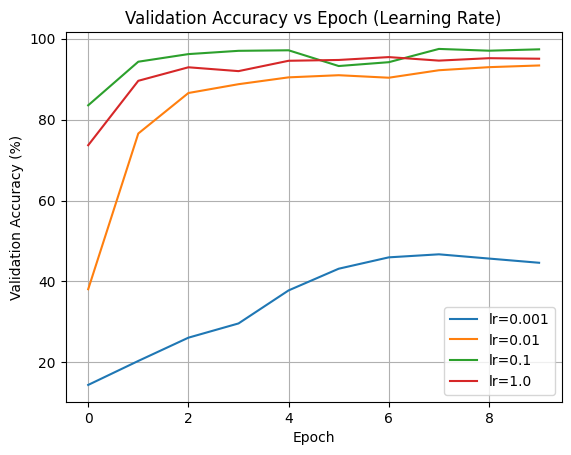

In [237]:
for lr in learning_rates:
    model = FeedforwardNN(hidden_sizes=[128,128,128]).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    tr_loss, val_loss, tr_acc, val_acc = train_model(
        model, train_loader, val_loader, optimizer, criterion, epochs=10
    )
    plt.plot(val_acc, label=f"lr={lr}")
    lr_summary.append((lr, val_acc[-1]))

plt.title("Validation Accuracy vs Epoch (Learning Rate)")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [238]:
lr_df = pd.DataFrame(lr_summary, columns=["Learning Rate", "Final Validation Accuracy (%)"])
print("\n=== Learning Rate Summary ===")
print(lr_df)


=== Learning Rate Summary ===
   Learning Rate  Final Validation Accuracy (%)
0          0.001                          44.62
1          0.010                          93.40
2          0.100                          97.39
3          1.000                          95.07


# B. Batch Size Analysis

In [239]:
batch_sizes = [16, 32, 64, 128]

In [240]:
bs_summary = []

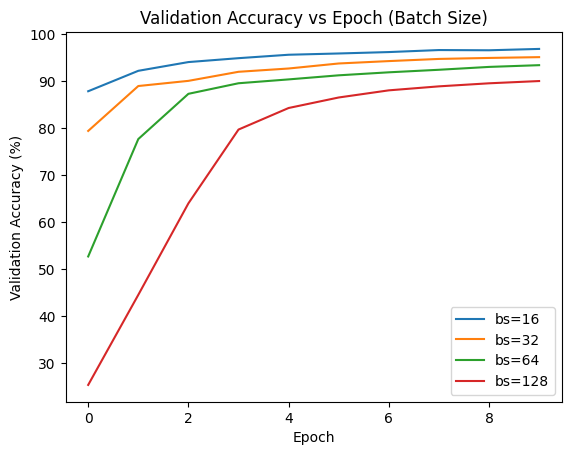

In [241]:
for bs in batch_sizes:
    train_loader = DataLoader(training_dataset, batch_size=bs, shuffle=True)
    val_loader = DataLoader(validation_dataset, batch_size=bs, shuffle=False)
    model = FeedforwardNN(hidden_sizes=[128,128,128]).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    start_time = time()
    _, _, _, val_acc = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10)
    elapsed = time() - start_time
    plt.plot(val_acc, label=f'bs={bs}')
    bs_summary.append((bs, val_acc[-1], round(elapsed, 1)))
plt.title('Validation Accuracy vs Epoch (Batch Size)')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.show()

In [242]:
bs_df = pd.DataFrame(bs_summary, columns=["Batch Size", "Final Validation Accuracy (%)", "Training Time (s)"])
print("\n=== Batch Size Summary ===")
print(bs_df)


=== Batch Size Summary ===
   Batch Size  Final Validation Accuracy (%)  Training Time (s)
0          16                          96.85               66.9
1          32                          95.10               48.6
2          64                          93.39               46.0
3         128                          90.01               51.9


# C. Architecture Analysis

In [243]:
# (1) Vary number of hidden layers
layer_configs = {
    "2_layers": [128, 128],
    "3_layers": [128, 128, 128],
    "4_layers": [128, 128, 128, 128],
    "5_layers": [128, 128, 128, 128, 128],
}

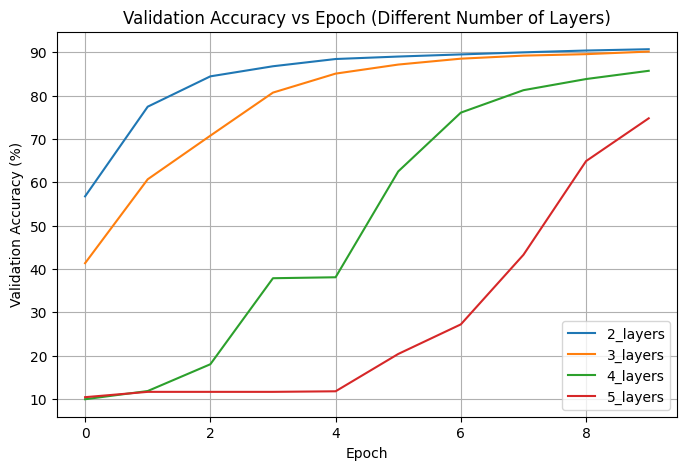

In [244]:
arch_results_layers = []
plt.figure(figsize=(8,5))
for name, config in layer_configs.items():
    model = FeedforwardNN(hidden_sizes=config).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    _, _, _, val_acc = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10)
    plt.plot(val_acc, label=name)
    arch_results_layers.append((name, val_acc[-1]))

plt.title('Validation Accuracy vs Epoch (Different Number of Layers)')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

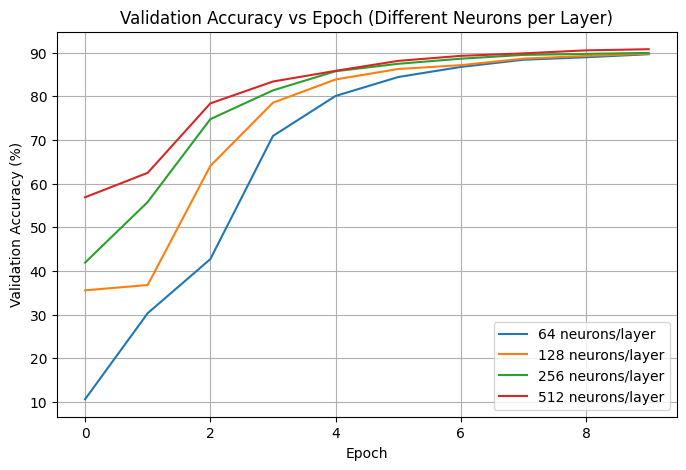

In [245]:
# (2) Vary neurons per layer (keep 3 layers)
neuron_configs = [64, 128, 256, 512]
arch_results_neurons = []
plt.figure(figsize=(8,5))
for n in neuron_configs:
    model = FeedforwardNN(hidden_sizes=[n, n, n]).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    _, _, _, val_acc = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10)
    plt.plot(val_acc, label=f"{n} neurons/layer")
    arch_results_neurons.append((f"3_layers_{n}_neurons", val_acc[-1]))

plt.title('Validation Accuracy vs Epoch (Different Neurons per Layer)')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

In [246]:
arch_df = pd.DataFrame(
    arch_results_layers + arch_results_neurons,
    columns=["Architecture", "Final Validation Accuracy (%)"]
)
print("\n=== Architecture Comparison Table ===")
print(arch_df)


=== Architecture Comparison Table ===
           Architecture  Final Validation Accuracy (%)
0              2_layers                          90.68
1              3_layers                          90.14
2              4_layers                          85.70
3              5_layers                          74.74
4   3_layers_64_neurons                          89.64
5  3_layers_128_neurons                          89.78
6  3_layers_256_neurons                          89.95
7  3_layers_512_neurons                          90.79
